<a href="https://colab.research.google.com/github/jyma14/Seminario_IA_DDAC_CIDETEQ/blob/main/DEMO1_SeminarioIA_SIREN_for_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use SIREN to model ODE systems.

--- created by Yuying Liu, 07/03/2020



In [1]:
# imports

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

#### Copy-Paste SIREN from the original work

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


In [3]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [4]:
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

#### Code up the Lorenz system

\begin{equation}
  \begin{split}
    \frac{dx}{dt} & = \sigma (y-x) \\
    \frac{dy}{dt} & = x(\rho-z) - y \\
    \frac{dz}{dt} & = xy - \beta z
  \end{split}
\end{equation}

where $\sigma = 10, \rho = 28, \beta = 8/3$. \\
Initial condition: $(-8, 7, 27)$

In [5]:
# Generate simulation data
n = 1000
T = 10
ts = np.linspace(0, T, n)

ntrain = int(n*0.7)
train_ts = ts[:ntrain]

sigma = 10
rho = 28
beta = 8/3

def lorenz_rhs(x):
    return np.array([sigma*(x[1]-x[0]), x[0]*(rho-x[2])-x[1], x[0]*x[1]-beta*x[2]])

x_init = [-8, 7, 27]
sol = integrate.solve_ivp(lambda _, x: lorenz_rhs(x), [0, T], x_init, t_eval=ts)
data = sol.y.T
train_data = data[:ntrain, :]

x_grads_true = sigma*(train_data[:, 1] - train_data[:, 0])
y_grads_true = train_data[:, 0]*(rho - train_data[:, 2]) - train_data[:, 1]
z_grads_true = train_data[:, 0]*train_data[:, 1] - beta*train_data[:, 2]

In [6]:
# SIREN representation for state variables
x = Siren(in_features=1, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True).cuda()
y = Siren(in_features=1, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True).cuda()
z = Siren(in_features=1, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True).cuda()

Step 0, Total loss 254.551224, loss on grad 13535.958984


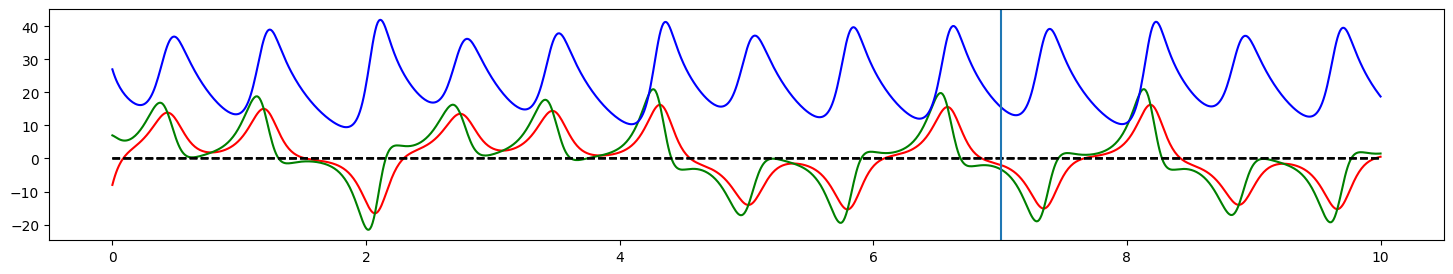

Step 2000, Total loss 4.902304, loss on grad 3475.208252


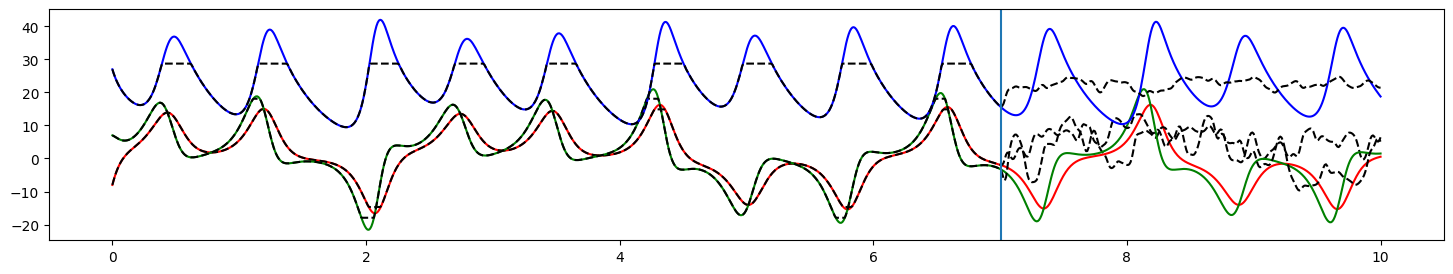

Step 4000, Total loss 0.205487, loss on grad 5730.335449


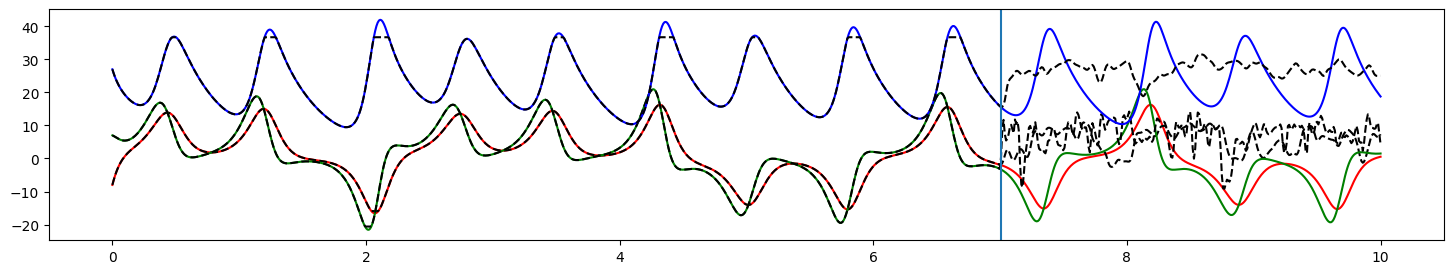

In [ ]:
# training
w = 1.0    # [pure state variable measurements] 1.0 --> 0.0 [pure derivative data]
train_with_real_derivative = True  # do we want to use real derivatives or relative relations?
total_steps = 20000
steps_til_summary = 2000

optim = torch.optim.Adam(lr=1e-4, params=list(x.parameters())+list(y.parameters())+list(z.parameters()))

for step in range(total_steps):
    # compute essential quantities
    sampled_xs, t1s = x(torch.tensor(train_ts).view(-1, 1).float().cuda())
    sampled_ys, t2s = y(torch.tensor(train_ts).view(-1, 1).float().cuda())
    sampled_zs, t3s = z(torch.tensor(train_ts).view(-1, 1).float().cuda())
    x_grads = gradient(sampled_xs, t1s)
    y_grads = gradient(sampled_ys, t2s)
    z_grads = gradient(sampled_zs, t3s)
    # compute loss
    state_loss = F.mse_loss(torch.cat([sampled_xs, sampled_ys, sampled_zs], dim=-1), torch.tensor(train_data).float().cuda())
    if train_with_real_derivative:
      # use real derivatives
      dx_loss = F.mse_loss(x_grads, torch.tensor(x_grads_true).view(-1, 1).float().cuda())
      dy_loss = F.mse_loss(y_grads, torch.tensor(y_grads_true).view(-1, 1).float().cuda())
      dz_loss = F.mse_loss(z_grads, torch.tensor(z_grads_true).view(-1, 1).float().cuda())
    else:
      # otherwise use constraints
      dx_loss = F.mse_loss(x_grads, sigma*(sampled_ys - sampled_xs))
      dy_loss = F.mse_loss(y_grads, sampled_xs*(rho - sampled_zs) - sampled_ys)
      dz_loss = F.mse_loss(z_grads , sampled_xs*sampled_ys - beta*sampled_zs)

    grad_loss = dx_loss + dy_loss + dz_loss
    loss = w * state_loss + (1 - w) * grad_loss

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f, loss on grad %0.6f" % (step, loss, grad_loss))
        # plot learned solution
        plt.figure(figsize=(18, 3))
        px = x(torch.tensor(ts).view(-1, 1).float().cuda())[0].detach().cpu().numpy()
        py = y(torch.tensor(ts).view(-1, 1).float().cuda())[0].detach().cpu().numpy()
        pz = z(torch.tensor(ts).view(-1, 1).float().cuda())[0].detach().cpu().numpy()
        plt.plot(ts, data[:, 0], 'r-', ts, px, 'k--')
        plt.plot(ts, data[:, 1], 'g-', ts, py, 'k--')
        plt.plot(ts, data[:, 2], 'b-', ts, pz, 'k--')
        plt.axvline(x=ts[ntrain])
        plt.show()
    # back-prop
    optim.zero_grad()
    loss.backward()
    optim.step()